In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())


True


In [14]:
def load_dataset(train_count=100, test_count=20, validation_count=20, image_x=224, image_y=224):
    dir = os.path.join(os.getcwd(), 'raw-img')

    image_paths = {}

    for folder in os.listdir(dir):
        image_paths[folder] = []
        folder_dir = os.path.join(dir, folder)
        
        for file in os.listdir(folder_dir):
            file_dir = os.path.join(folder_dir, file)
            image_paths[folder].append(file_dir)

    num_of_classes = 10
    values = np.arange(num_of_classes)

    target_train = np.repeat(values, train_count)
    target_test = np.repeat(values, test_count)
    target_validation = np.repeat(values, validation_count)

    images_train = np.ndarray((train_count * num_of_classes, image_y, image_x, 3))
    images_test = np.ndarray((test_count * num_of_classes, image_y, image_x, 3))
    images_validation = np.ndarray((validation_count * num_of_classes, image_y, image_x, 3))

    images_train_idx = 0
    images_test_idx = 0
    images_validation_idx = 0

    for _, image_paths in image_paths.items():
        class_image_paths = image_paths[:train_count + test_count + validation_count]

        for i, file_path in enumerate(class_image_paths):
            img = cv2.imread(file_path)
            img = cv2.resize(img, (image_x, image_y))
            img = img.astype('float32')
            img /= 255.0 
            
            if i < train_count:
                images_train[images_train_idx] = img
                images_train_idx += 1
            elif i < train_count + test_count:
                images_test[images_test_idx] = img
                images_test_idx += 1
            else:
                images_validation[images_validation_idx] = img
                images_validation_idx += 1

    permutation_train = np.random.permutation(train_count * num_of_classes)
    permutation_test = np.random.permutation(test_count * num_of_classes)
    permutation_validation = np.random.permutation(validation_count * num_of_classes)

    images_train = images_train[permutation_train]
    target_train = target_train[permutation_train]

    images_test = images_test[permutation_test]
    target_test = target_test[permutation_test]

    images_validation = images_validation[permutation_validation]
    target_validation = target_validation[permutation_validation]

    return images_train, target_train, images_test, target_test, images_validation, target_validation


In [15]:
x_train, y_train, x_test, y_test, x_validation, y_validation = load_dataset()

In [16]:
print(x_train.shape)

(1000, 224, 224, 3)


In [17]:
train_x_tensor = torch.from_numpy(x_train).float().to(device)
train_x_tensor = train_x_tensor.permute(0, 3, 1, 2)
train_y_tensor = torch.from_numpy(y_train).long().to(device)

test_x_tensor = torch.from_numpy(x_test).float().to(device)
test_x_tensor = test_x_tensor.permute(0, 3, 1, 2)
test_y_tensor = torch.from_numpy(y_test).long().to(device)

val_x_tensor = torch.from_numpy(x_validation).float().to(device)
val_x_tensor = val_x_tensor.permute(0, 3, 1, 2)
val_y_tensor = torch.from_numpy(y_validation).long().to(device)

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor,val_y_tensor)
test_dataset = TensorDataset(test_x_tensor,test_y_tensor)

In [18]:
class Model(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.0):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [43]:
batch_sizes = [30,60,90]
learning_rates = [0.01,0.001,0.0001]

In [44]:
def train_model(train_loader,lr,num_epochs=100, dropout_prob=0.0):
    
    model = Model(dropout_prob=dropout_prob).to(device)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(epoch)
            
    return model,running_loss

In [21]:
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():

        for inputs, targets in test_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    
    return accuracy

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, loader):
    model.eval()

    predictions = []
    targets = []

    with torch.no_grad():
        for inputs, labels in loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())


    c = confusion_matrix(targets, predictions)

    label = range(10)

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2) 

    sns.heatmap(c, annot=True, xticklabels=label, yticklabels=label)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [55]:
def test_different_models(batch_size_list, learning_rate_list):

    best_index = 0
    accuracy_and_loss = []
    for i, batch_size in enumerate(batch_size_list):
        for i2, lr in enumerate(learning_rate_list):
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
           
            model,running_loss = train_model(train_loader,lr)

            test_accuracy = evaluate_model(model,test_loader)
            val_accuracy = evaluate_model(model,val_loader)  
            accuracy_and_loss.append((val_accuracy,test_accuracy,running_loss / len(train_loader)))

            if val_accuracy > accuracy_and_loss[best_index][0]:
                best_index = i * 3 + i2
        
            print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Val Accuracy: {val_accuracy}, Test Accuracy{test_accuracy}, Loss: {running_loss / len(train_loader)}")   
   
    return accuracy_and_loss, best_index

In [56]:
results, best_index = test_different_models(batch_sizes, learning_rates)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Learning Rate: 0.01, Batch Size: 30, Val Accuracy: 0.1, Test Accuracy0.1, Loss: 2.304520810351652
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Learning Rate: 0.001, Batch Size: 30, Val Accuracy: 0.32, Test Accuracy0.26, Loss: 7.0007779012324616e-06
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
7

In [57]:
x_labels = ['30 batch, 0.01 lr',
 '30 batch, 0.001 lr',
 '30 batch, 0.0001 lr',
 '60 batch, 0.01 lr',
 '60 batch, 0.001 lr',
 '60 batch, 0.0001 lr',
 '90 batch, 0.01 lr',
 '90 batch, 0.001 lr',
 '90 batch, 0.0001 lr']

va = [i[0] for i in results]
ta = [i[1] for i in results]
l = [i[2] for i in results]

def plot_combination_result(title, labels, values):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Configuration', fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.title(title + ' by Configuration', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

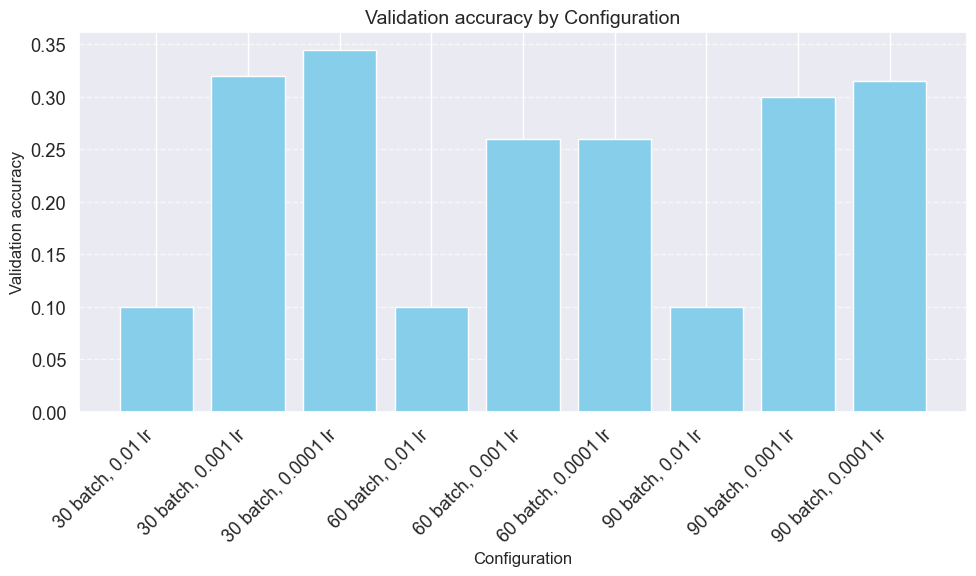

In [58]:
plot_combination_result("Validation accuracy",x_labels,va)

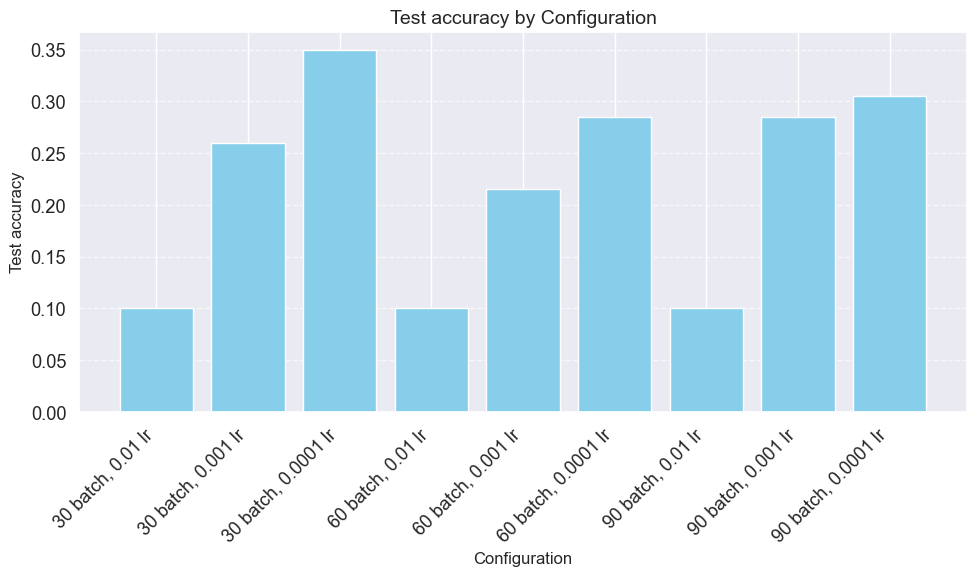

In [59]:
plot_combination_result("Test accuracy",x_labels,ta)

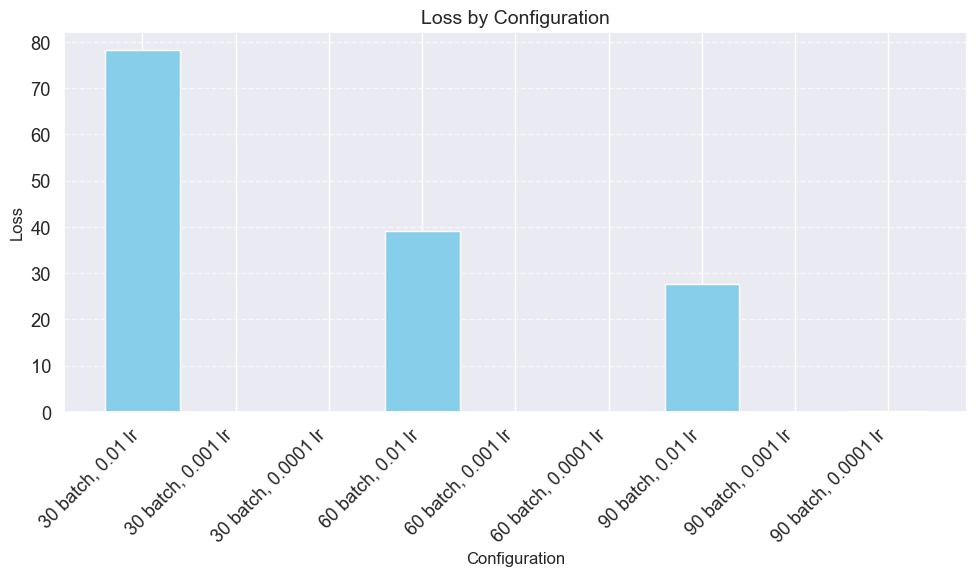

In [60]:
plot_combination_result("Loss",x_labels,l)

In [61]:
batch_size = 30
lr = 0.0001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

best_model, _ = train_model(train_loader,lr)

torch.save(best_model.state_dict(), 'model.pth')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


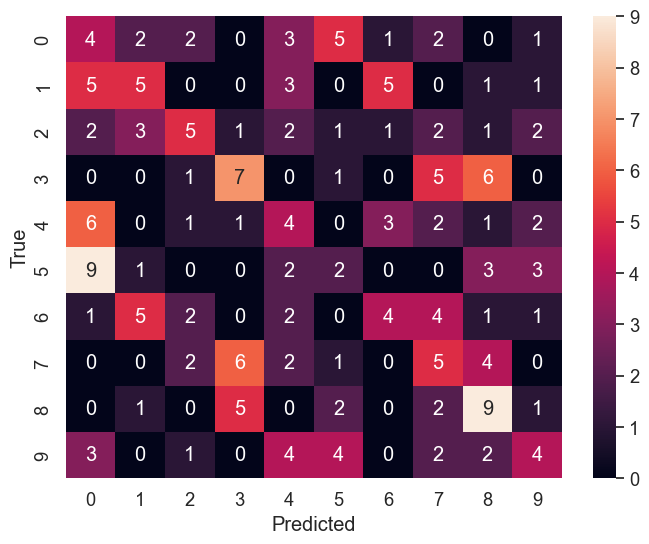

In [63]:
plot_cm(best_model, test_loader)

In [27]:
pretrained_model_path = 'model.pth'
pretrained_dict = torch.load(pretrained_model_path)

In [68]:
def test_dropout(dropout_list):
    dropout_results = []
    best_index = 0
    for i, dropout_prob in enumerate(dropout_list):

        model , loss = train_model(train_loader,lr,100,dropout_prob)

        validation_accuracy = evaluate_model(model,val_loader)
        test_accuracy = evaluate_model(model,test_loader)
        dropout_results.append((validation_accuracy,test_accuracy,loss))

        if dropout_results[i][1] > dropout_results[best_index][1]:
            best_index = i

        print(f"Dropout:", dropout_prob,"Validation:", validation_accuracy,"Test:", test_accuracy,"Loss: ",loss / len(train_loader) )

    return dropout_results, best_index

In [69]:
dropout_result, dropout_best = test_dropout([0.1,0.3, 0.6, 0.9])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Dropout: 0.1 Validation: 0.33 Test: 0.27 Loss:  0.01205206463996814
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Dropout: 0.3 Validation: 0.225 Test: 0.24 Loss:  0.039078097679200306
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
9

In [76]:
from efficientnet_pytorch import EfficientNet

num_classes = 10

first_model = EfficientNet.from_pretrained('efficientnet-b0')
second_model = EfficientNet.from_pretrained('efficientnet-b0')

for param in first_model.parameters():
    param.requires_grad = False

for param in second_model.parameters():
    param.requires_grad = False

in_features1 = first_model._fc.in_features
first_model._fc = nn.Linear(in_features1, num_classes)

in_features2 = second_model._fc.in_features
second_model._fc = nn.Linear(in_features2, num_classes)

layers_to_unfreeze = ['_blocks.16', '_blocks.17', '_fc']
for name, param in second_model.named_parameters():
    if any(layer_name in name for layer_name in layers_to_unfreeze):
        param.requires_grad = True

first_model = first_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(first_model.parameters(), lr=lr)

for epoch in range(100):
    torch.cuda.empty_cache()
    first_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = first_model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(epoch)

second_model = second_model.to(device)
optimizer2 = optim.Adam(second_model.parameters(), lr=lr)

for epoch in range(100):
    torch.cuda.empty_cache()
    second_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer2.zero_grad()

        outputs = second_model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer2.step()

        running_loss += loss.item()

    print(epoch)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [77]:
model_1_validation = evaluate_model(first_model,val_loader)
model_1_test = evaluate_model(first_model,test_loader)

model_2_validation = evaluate_model(second_model,val_loader)
model_2_test = evaluate_model(second_model,test_loader)

In [78]:
print("First model val: ",model_1_validation, "test: ", model_1_test)
print("Second model val: ",model_2_validation, "test: ", model_2_test)

First model val:  0.89 test:  0.92
Second model val:  0.87 test:  0.9


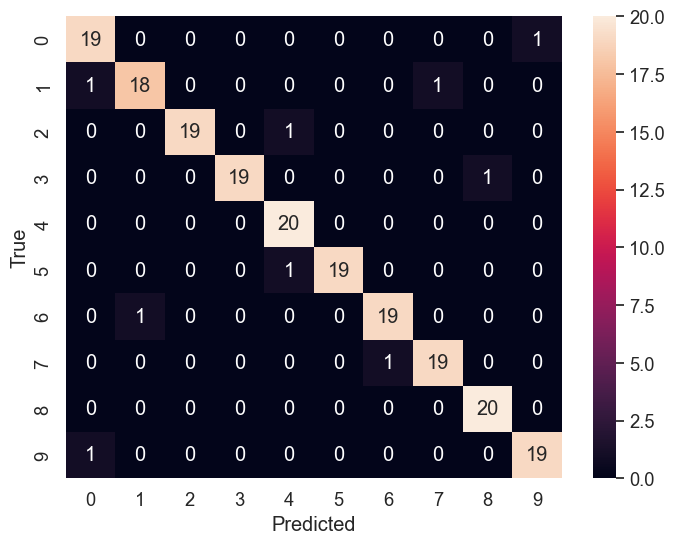

In [79]:
plot_cm(first_model, test_loader)